<a href="https://colab.research.google.com/github/m1kemp/ecgDiagnosis/blob/main/ColabCode/FullImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#DownLoad PhysioNet and MIT-BIH datasets
import os
import requests

# URL of PhysioNet dataset
DATA_URL_PHYSIONET = "https://physionet.org/static/published-projects/challenge-2017/1.0.0/training2017.zip"
SAVE_PATH_PHYSIONET = "data/training2017.zip"

# URL of MIT-BIH dataset
DATA_URL_MITBIH = "https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
SAVE_PATH_MITBIH = "data/mit-bih-arrhythmia-database-1.0.0.zip"

def download_data(DATA_URL, SAVE_PATH):
    if not os.path.exists("data"):
        os.makedirs("data")

    print("Downloading dataset...")
    response = requests.get(DATA_URL, stream=True)

    with open(SAVE_PATH, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Download complete! Unzipping...")
    os.system(f"unzip {SAVE_PATH} -d data/")
    print("Dataset is ready.")

    # Delete the zip file
    os.remove(SAVE_PATH)
    print(f"Deleted zip file: {SAVE_PATH}")

download_data(DATA_URL_PHYSIONET, SAVE_PATH_PHYSIONET)
download_data(DATA_URL_MITBIH, SAVE_PATH_MITBIH)

Download complete! Unzipping...
Dataset is ready.
Deleted zip file: data/training2017.zip
Download complete! Unzipping...
Dataset is ready.
Deleted zip file: data/mit-bih-arrhythmia-database-1.0.0.zip


In [2]:
# Install required packages
!pip install wfdb
!pip install neurokit2
!pip install biosppy
!pip install torch
!pip install pickle
!pip install gzip
!pip install peakutils

# Preprocessing for Physionet Dataset
import os
import numpy as np
import pandas as pd
import wfdb
import scipy.io
import scipy.signal
import neurokit2 as nk
import biosppy.signals.ecg as ecg
import torch
import gzip
import pickle

# Define constants
TARGET_SAMPLING_RATE = 125  # Hz
MAX_LEN_PHYSIONET = 10 * TARGET_SAMPLING_RATE  # 10 seconds
MAX_LEN_MITBIH = 30 * TARGET_SAMPLING_RATE  # 30 seconds

# Load PhysioNet dataset
def load_physionet_data(path):
    """Load PhysioNet 2017 dataset from .mat files and reference.csv."""
    signals, labels = [], []
    ref_df = pd.read_csv(os.path.join(path, "REFERENCE.csv"), header=None)
    ref_dict = dict(zip(ref_df[0], ref_df[1]))
    label_mapping = {"N": 0, "A": 1, "O": 2, "~": 3}  # Modify as per dataset classes


    for file in os.listdir(path):
        if file.endswith(".mat"):
            record_name = file.replace(".mat", "")
            mat_data = scipy.io.loadmat(os.path.join(path, file))
            signal = mat_data["val"][0]  # Extract ECG lead
            label = ref_dict.get(record_name, None)
            if label:
                signals.append(signal)
                physionet_labels = label_mapping[label]
                labels.append(physionet_labels)

    return signals, labels



# Downsampling function
def downsample_signal(signal, original_fs, target_fs=125):
    """Downsample ECG signal from original_fs to target_fs."""
    num_samples = int(len(signal) * target_fs / original_fs)
    return scipy.signal.resample(signal, num_samples)

# Normalize function
def normalize_signal(signal):
    """Normalize ECG signal between 0 and 1."""
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# R-peak detection
def detect_r_peaks(signal, sampling_rate=125):
    """Detect R-peaks using the Pan-Tompkins algorithm."""
    _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
    return np.array(r_peaks["ECG_R_Peaks"])
# Extract T-episodes
def extract_t_episodes(signal, r_peaks, fs):
    """T-episodes are intervals centered on R-peaks of length median(R-R interval)."""
    if len(r_peaks) < 2:
        return []
    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []
    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        episodes.append((start, end))
    return episodes

# Zero-padding
def pad_signal(signal, max_len=MAX_LEN_PHYSIONET):
    """Pad signal to max_len with zeros."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

# Full preprocessing pipeline
def preprocess_ecg_dataset(dataset_path):
    """Preprocess ECG dataset from PhysioNet or MIT-BIH."""
    signals, labels = load_physionet_data(dataset_path)
    original_fs = 300  # PhysioNet signals are sampled at 300 Hz
    max_len = MAX_LEN_PHYSIONET
    processed_signals,processed_labels = [],[]
    for signal,label in zip(signals,labels):
        # 1. Downsampling
        signal = downsample_signal(signal, original_fs, TARGET_SAMPLING_RATE)
        # 2. Normalization
        signal = normalize_signal(signal)
        # 3. R-peak detection
        r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)
        #4. T-episode and beat extraction
        t_eps = extract_t_episodes(signal, r_peaks, TARGET_SAMPLING_RATE)
        for start, end in t_eps:
            beat = signal[start:end]
            processed_signals.append(pad_signal(beat, max_len))
            processed_labels.append(label)

    return np.array(processed_signals), np.array(processed_labels)

# Example Usage
physionet_data, physionet_labels = preprocess_ecg_dataset("data/training2017")

# Convert to PyTorch Tensors
X_physionet = torch.tensor(physionet_data, dtype=torch.float32)
y_physionet = torch.tensor(physionet_labels, dtype=torch.long)

#save the processed data
# Save data with gzip compression
with gzip.open("pretraining_data.pkl.gz", "wb") as f:
    pickle.dump((X_physionet, y_physionet), f)
print(f"PhysioNet Data Shape: {X_physionet.shape}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 141.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 

In [3]:
%%writefile NNModel.py
import torch
import torch.nn as nn
import torch.nn.functional as F
# My Model
# Squeeze-and-Excitation (SE) Module
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _ = x.shape
        se = self.global_avg_pool(x).view(batch, channels)  # Global Avg Pool
        se = F.relu(self.fc1(se))  # First FC + ReLU
        se = F.softmax(self.fc2(se), dim=1)  # Second FC + Softmax
        se = se.view(batch, channels, 1)
        return x * se  # Scale the input

# Residual Block with SE Module
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(ResidualBlock, self).__init__()
        self.maxpool = nn.MaxPool1d(kernel_size=2)  # Add MaxPooling layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.se = SEBlock(out_channels)
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()



    def forward(self, x):
        x= self.maxpool(x)  # Apply MaxPooling
        residual = self.shortcut(x)  # Skip connection
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.conv2(out)
        out = self.se(out)  # Apply SE Module
        out += residual  # Add Skip Connection
        return F.relu(out)

# Full Model: CNN + BiLSTM + FC
class ECGClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGClassifier, self).__init__()

        # Initial Convolutional Layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)

        # Residual Blocks with SE Module (4 Blocks)
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 96)
        self.resblock3 = ResidualBlock(96, 128)
        self.resblock4 = ResidualBlock(128, 160)

        # MaxPooling Layer
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # BiLSTM Layers
        self.lstm = nn.LSTM(160, 64, num_layers=2, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 64)  # BiLSTM outputs 64*2=128
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
         # First Conv -> ReLU -> BatchNorm
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)

        # Second Conv -> ReLU -> BatchNorm
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)

        # Residual Blocks with SE Module
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)


        # Reshape for LSTM (Batch, SeqLen, Features)
        x = x.permute(0, 2, 1)

        # BiLSTM
        x, _ = self.lstm(x)
        x = self.dropout1(x[:, -1, :])  # Take last LSTM output
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  # Softmax for classification

# Create Model Instance
model = ECGClassifier(num_classes=5)

print(model)

Writing NNModel.py


In [4]:
# Pretraining with PhysioNet Data
!pip install nbimporter

import torch
import torch.nn as nn
import torch.optim as optim
import nbimporter
from NNModel import ECGClassifier
import pickle
import gzip

# Load Pretraining Data (PhysioNet)
with gzip.open("pretraining_data.pkl.gz", "rb") as f:
    X_train, y_train = pickle.load(f)

# Convert to PyTorch Dataset
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.unsqueeze(1)  # Add channel dimension
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
batch_size = 64
train_dataset = ECGDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Modify Model for Pretraining (Last FC Layer = 4 Classes)
class PretrainECGClassifier(ECGClassifier):
    def __init__(self):
        super(PretrainECGClassifier, self).__init__(num_classes=4)  # Change output classes to 4

# Initialize Model
model = PretrainECGClassifier()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# He Normal Initialization
def he_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

model.apply(he_init)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pretraining Loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Save Pretrained Model with gzip and pickle
with gzip.open("pretrained_model.pth.gz", "wb") as f:
    pickle.dump(model.state_dict(), f)
print("Pretraining Complete. Model Saved as pretrained_model.pth.gz!")

ECGClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (se): SEBlock(
      (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (shortcut): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  )
  (resblock2): ResidualBlock(
    

In [5]:
# Preprocessing for MIT-BIH Dataset
import os
import numpy as np
import torch
import wfdb
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

# Constants
TARGET_SAMPLING_RATE = 125
MAX_LEN_MITBIH = 30 * TARGET_SAMPLING_RATE  # 30 seconds

# Beat label mapping
label_mapping = {
    'N': 0, 'L': 0, 'R': 0, 'B':0,                            # N class
    'A': 1, 'a': 1, 'J': 1, 'S': 1,'e':1,'j':1,'n':1,          # S class
    'V': 2, 'r': 2, 'E': 2,                                   # V class
    'F': 3,                                                   # F class
    '/': 4, 'Q': 4,'f':4, '?':4                                          # Q class
}


def load_mitbih_record(record_path):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    signal = record.p_signal[:, 0]  # use first ECG lead
    return signal, annotation.sample, annotation.symbol

def downsample_signal(signal, original_fs=360, target_fs=125):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-6)

def detect_r_peaks(signal, fs=125):
    """Use NeuroKit2 to detect R-peaks."""
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
    return rpeaks["ECG_R_Peaks"]

def extract_t_episodes(signal, r_peaks, fs):
    if len(r_peaks) < 2:
        return []
    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []
    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        episodes.append((start, end))
    return episodes

def assign_labels_to_episodes(episodes, ann_samples, ann_symbols, label_map):
    labels = []
    for start, end in episodes:
        center = (start + end) // 2
        nearest_idx = np.argmin(np.abs(np.array(ann_samples) - center))
        label = ann_symbols[nearest_idx]
        if label in label_map:
            labels.append(label_map[label])
        else:
            labels.append(None)
    return labels

def pad_signal(signal, max_len):
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_mitbih_dataset(dataset_dir):
    all_beats, all_labels = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith('.dat'):
            record_name = file.replace('.dat', '')
            signal, ann_samples, ann_symbols = load_mitbih_record(os.path.join(dataset_dir, record_name))
            # Downsample signal
            signal = downsample_signal(signal)
            ann_samples = (np.array(ann_samples) * (TARGET_SAMPLING_RATE / 360)).astype(int)
            # Normalize
            signal = normalize_signal(signal)
            # R-peak detection using NeuroKit
            r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)
            # Extract T-episodes
            t_episodes = extract_t_episodes(signal, r_peaks, TARGET_SAMPLING_RATE)
            # Match to labels
            labels = assign_labels_to_episodes(t_episodes, ann_samples, ann_symbols, label_mapping)
            for (start, end), label in zip(t_episodes, labels):
                if label is not None:
                    beat = signal[start:end]
                    padded = pad_signal(beat, MAX_LEN_MITBIH)
                    all_beats.append(padded)
                    all_labels.append(label)
    return np.array(all_beats), np.array(all_labels)

# Preprocess MIT-BIH
mitbih_signals, mitbih_labels = preprocess_mitbih_dataset("data/mit-bih-arrhythmia-database-1.0.0")

# Convert to PyTorch tensors
X_mitbih = torch.tensor(mitbih_signals, dtype=torch.float32)
y_mitbih = torch.tensor(mitbih_labels, dtype=torch.long)

# Save
with gzip.open("mitbih_beats.pkl.gz", "wb") as f:
    pickle.dump((X_mitbih, y_mitbih), f)

print(f"MIT-BIH Beats Shape: {X_mitbih.shape}")
print(f"Unique Labels: {np.unique(mitbih_labels, return_counts=True)}")


MIT-BIH Beats Shape: torch.Size([108633, 3750])
Unique Labels: (array([0, 1, 2, 3, 4]), array([89864,  2955,  7003,   799,  8012]))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/ColabData/ECG/mit-bih-arrhythmia-database.zip /content/
!cp /content/drive/MyDrive/ColabData/ECG/pretrained_model.pth.gz /content/
!cp /content/drive/MyDrive/ColabData/ECG/pretraining_data.pkl.gz /content/ # Corrected file name

Mounted at /content/drive


In [6]:
# Preprocessing for MIT-BIH Dataset
import os
import numpy as np
import torch
import wfdb
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

# Constants
TARGET_SAMPLING_RATE = 125
MAX_LEN_MITBIH = 30 * TARGET_SAMPLING_RATE  # 30 seconds

# Beat label mapping
label_mapping = {
    'N': 0, 'L': 0, 'R': 0, 'B':0,                            # N class
    'A': 1, 'a': 1, 'J': 1, 'S': 1,'e':1,'j':1,'n':1,          # S class
    'V': 2, 'r': 2, 'E': 2,                                   # V class
    'F': 3,                                                   # F class
    '/': 4, 'Q': 4,'f':4, '?':4                                          # Q class
}


def load_mitbih_record(record_path):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    signal = record.p_signal[:, 0]  # use first ECG lead
    return signal, annotation.sample, annotation.symbol

def downsample_signal(signal, original_fs=360, target_fs=125):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-6)

def detect_r_peaks(signal, fs=125):
    """Use NeuroKit2 to detect R-peaks."""
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
    return rpeaks["ECG_R_Peaks"]

def extract_t_episodes(signal, r_peaks, fs):
    if len(r_peaks) < 2:
        return []
    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []
    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        episodes.append((start, end))
    return episodes

def assign_labels_to_episodes(episodes, ann_samples, ann_symbols, label_map):
    labels = []
    for start, end in episodes:
        center = (start + end) // 2
        nearest_idx = np.argmin(np.abs(np.array(ann_samples) - center))
        label = ann_symbols[nearest_idx]
        if label in label_map:
            labels.append(label_map[label])
        else:
            labels.append(None)
    return labels

def pad_signal(signal, max_len):
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_mitbih_dataset(dataset_dir):
    all_beats, all_labels = [], []
    for file in os.listdir(dataset_dir):
        if file.endswith('.dat'):
            record_name = file.replace('.dat', '')
            signal, ann_samples, ann_symbols = load_mitbih_record(os.path.join(dataset_dir, record_name))
            # Downsample signal
            signal = downsample_signal(signal)
            ann_samples = (np.array(ann_samples) * (TARGET_SAMPLING_RATE / 360)).astype(int)
            # Normalize
            signal = normalize_signal(signal)
            # R-peak detection using NeuroKit
            r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)
            # Extract T-episodes
            t_episodes = extract_t_episodes(signal, r_peaks, TARGET_SAMPLING_RATE)
            # Match to labels
            labels = assign_labels_to_episodes(t_episodes, ann_samples, ann_symbols, label_mapping)
            for (start, end), label in zip(t_episodes, labels):
                if label is not None:
                    beat = signal[start:end]
                    padded = pad_signal(beat, MAX_LEN_MITBIH)
                    all_beats.append(padded)
                    all_labels.append(label)
    return np.array(all_beats), np.array(all_labels)

# Preprocess MIT-BIH
mitbih_signals, mitbih_labels = preprocess_mitbih_dataset("data/mit-bih-arrhythmia-database-1.0.0")

# Convert to PyTorch tensors
X_mitbih = torch.tensor(mitbih_signals, dtype=torch.float32)
y_mitbih = torch.tensor(mitbih_labels, dtype=torch.long)

# Save
with gzip.open("mitbih_beats.pkl.gz", "wb") as f:
    pickle.dump((X_mitbih, y_mitbih), f)

print(f"MIT-BIH Beats Shape: {X_mitbih.shape}")
print(f"Unique Labels: {np.unique(mitbih_labels, return_counts=True)}")

MIT-BIH Beats Shape: torch.Size([108633, 3750])
Unique Labels: (array([0, 1, 2, 3, 4]), array([89864,  2955,  7003,   799,  8012]))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score,precision_score, recall_score, f1_score,roc_curve, auc
from NNModel import ECGClassifier  # Make sure this is implemented correctly
import matplotlib.pyplot as plt
from google.colab import drive # Import drive


# --------------------
# 1. Load and Split Data
# --------------------
with gzip.open("mitbih_beats.pkl.gz", "rb") as f:
    X_mit, y_mit = pickle.load(f)

# Train-Test Split (Stratified, 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_mit, y_mit, test_size=0.2, random_state=42, stratify=y_mit
)

# --------------------
# 2. Define Dataset Class
# --------------------
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.unsqueeze(1)  # Shape: (B, 1, L)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------------------
# 3. Create DataLoaders
# --------------------
batch_size = 250
train_loader = torch.utils.data.DataLoader(ECGDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ECGDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# --------------------
# 4. Model Initialization
# --------------------
model = ECGClassifier(num_classes=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load Pretrained Weights (excluding last FC layer)
with gzip.open("pretrained_model.pth.gz", "rb") as f:
    pretrained_dict = pickle.load(f)

pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('fc2')}
model.load_state_dict(pretrained_dict, strict=False)

# Replace last FC layer
model.fc2 = nn.Linear(model.fc2.in_features, 5).to(device)

# --------------------
# 5. Training Setup
# --------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
num_epochs = 100

# --------------------
# 6. Training Loop
# --------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}")

    # Save the fine-tuned model
model_path = "ecg_mitbih_finetuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Mount Google Drive
drive.mount('/content/drive')

# Save to Google Drive (change the path as needed)
model_path = "/content/drive/MyDrive/ecg_mitbih_finetuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")



[Epoch 1/100] Loss: 0.2212
[Epoch 2/100] Loss: 0.0717
[Epoch 3/100] Loss: 0.0520
[Epoch 4/100] Loss: 0.0431
[Epoch 5/100] Loss: 0.0384
[Epoch 6/100] Loss: 0.0355
[Epoch 7/100] Loss: 0.0309
[Epoch 8/100] Loss: 0.0325
[Epoch 9/100] Loss: 0.0281
[Epoch 10/100] Loss: 0.0274
[Epoch 11/100] Loss: 0.0249
[Epoch 12/100] Loss: 0.0240
[Epoch 13/100] Loss: 0.0215
[Epoch 14/100] Loss: 0.0222
[Epoch 15/100] Loss: 0.0219
[Epoch 16/100] Loss: 0.0207
[Epoch 17/100] Loss: 0.0190
[Epoch 18/100] Loss: 0.0196
[Epoch 19/100] Loss: 0.0204
[Epoch 20/100] Loss: 0.0209
[Epoch 21/100] Loss: 0.0168
[Epoch 22/100] Loss: 0.0184
[Epoch 23/100] Loss: 0.0155
[Epoch 24/100] Loss: 0.0171
[Epoch 25/100] Loss: 0.0166
[Epoch 26/100] Loss: 0.0152
[Epoch 27/100] Loss: 0.0173
[Epoch 28/100] Loss: 0.0151
[Epoch 29/100] Loss: 0.0137
[Epoch 30/100] Loss: 0.0158
[Epoch 31/100] Loss: 0.0127
[Epoch 32/100] Loss: 0.0141
[Epoch 33/100] Loss: 0.0154
[Epoch 34/100] Loss: 0.0137
[Epoch 35/100] Loss: 0.0130
[Epoch 36/100] Loss: 0.0127
[

In [8]:
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, digits=4))
print("\n=== Accuracy ===", accuracy_score(all_labels, all_preds))
print("\n=== Precision ===", precision_score(all_labels, all_preds, average='weighted'))
print("\n=== Recall ===", recall_score(all_labels, all_preds, average='weighted'))
print("\n=== F1 Score ===", f1_score(all_labels, all_preds, average='weighted'))

try:
    y_true_bin = np.eye(5)[all_labels]
    auc_score = roc_auc_score(y_true_bin, all_probs, multi_class='ovr')
    print(f"Multiclass ROC-AUC Score: {auc_score:.4f}")
except ValueError as e:
    print("ROC-AUC calculation skipped:", e)

for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    class_auc = auc(fpr, tpr)
    print(f"Class {i} AUC: {class_auc:.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9887    0.9992    0.9939     17973
           1     0.9739    0.8223    0.8917       591
           2     0.9985    0.9272    0.9615      1401
           3     0.7711    0.8000    0.7853       160
           4     0.9969    0.9944    0.9956      1602

    accuracy                         0.9879     21727
   macro avg     0.9458    0.9086    0.9256     21727
weighted avg     0.9879    0.9879    0.9876     21727


=== Accuracy === 0.9878952455470152

=== Precision === 0.9879391966847019

=== Recall === 0.9878952455470152

=== F1 Score === 0.9876333352738639
Multiclass ROC-AUC Score: 0.9953
Class 0 AUC: 0.9945
Class 1 AUC: 0.9948
Class 2 AUC: 0.9993
Class 3 AUC: 0.9884
Class 4 AUC: 0.9998


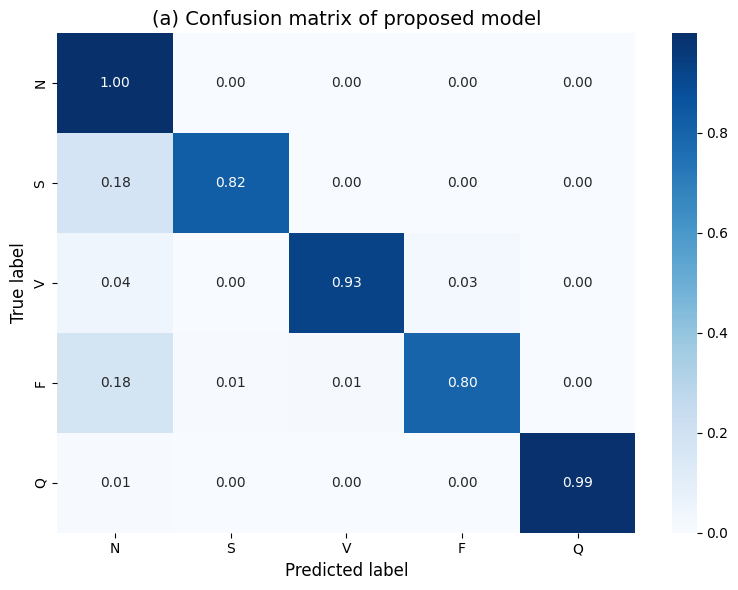

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class labels (adjust if your class labels are different)
class_names = ['N', 'S', 'V', 'F', 'Q']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.title("(a) Confusion matrix of proposed model", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

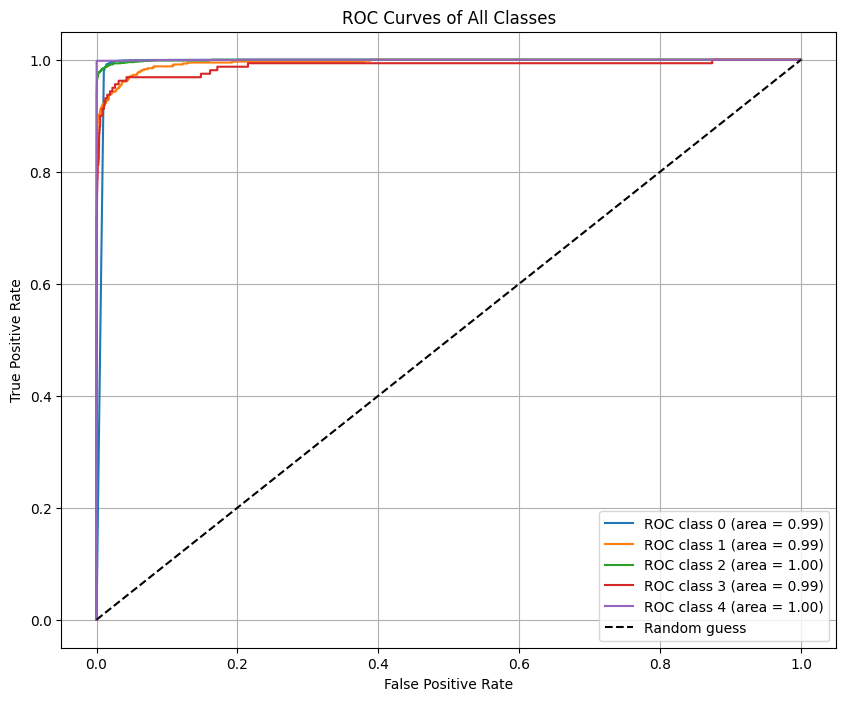

In [10]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC class {i} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of All Classes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [13]:
import gzip, pickle
with gzip.open("ptbdb_beats.pkl.gz", "rb") as f:
    X_ptbdb, y_ptbdb = pickle.load(f)
print(X_ptbdb.shape, y_ptbdb.shape)

torch.Size([38084, 250]) torch.Size([38084])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --------------------
# 1. Train/Test Split
# --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_ptbdb, y_ptbdb, test_size=0.2, stratify=y_ptbdb, random_state=42
)

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)  # (B, 1, L)
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)

# Weighted sampler για balanced training
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train.numpy()), y=y_train.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

sample_weights = class_weights[y_train.numpy()]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# --------------------
# 2. Load Model
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGClassifier(num_classes=5).to(device)

# αντικαθιστούμε το head για PTBDB (5 κλάσεις)
model.fc2 = nn.Linear(model.fc2.in_features, 5).to(device)

# φόρτωση pretrained weights από MIT-BIH
model.load_state_dict(torch.load("ecg_mitbih_finetuned.pth", map_location=device))

# Freeze convolutional layers (κρατάμε μόνο classifier head trainable)
for name, param in model.named_parameters():
    if "fc" not in name:  # αφήνουμε trainable μόνο fc layers
        param.requires_grad = False

# --------------------
# 3. Training Setup
# --------------------
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# --------------------
# 4. Training Loop
# --------------------
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

# --------------------
# 5. Evaluation
# --------------------
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_true, all_preds))
print("F1-score (weighted):", f1_score(all_true, all_preds, average="weighted"))
print("\nClassification Report:\n", classification_report(all_true, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_true, all_preds))


Epoch 1/10, Loss: 14.1375, Train Acc: 0.2603
Epoch 2/10, Loss: 2.6047, Train Acc: 0.2922
Epoch 3/10, Loss: 1.5727, Train Acc: 0.2674
Epoch 4/10, Loss: 1.1422, Train Acc: 0.2793
Epoch 5/10, Loss: 0.9862, Train Acc: 0.2832
Epoch 6/10, Loss: 0.8603, Train Acc: 0.2923
Epoch 7/10, Loss: 0.7976, Train Acc: 0.2878
Epoch 8/10, Loss: 0.7487, Train Acc: 0.2712
Epoch 9/10, Loss: 0.7225, Train Acc: 0.2746
Epoch 10/10, Loss: 0.6979, Train Acc: 0.2799
Test Accuracy: 0.05605881580674806
F1-score (weighted): 0.03037601609290576

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.01      0.03      1419
           1       0.17      0.06      0.09      1108
           2       1.00      0.00      0.00      4295
           3       0.03      0.98      0.05       101
           4       0.07      0.34      0.12       694

    accuracy                           0.06      7617
   macro avg       0.30      0.28      0.06      7617
weighted avg       0.64

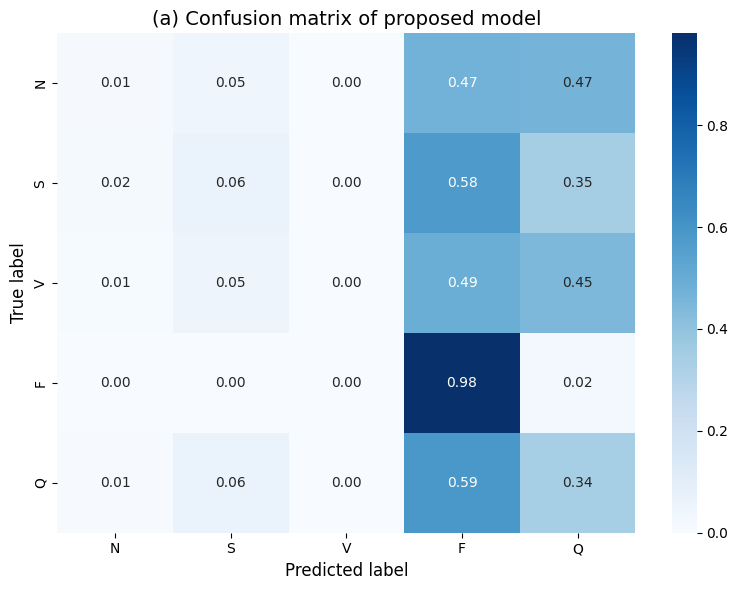

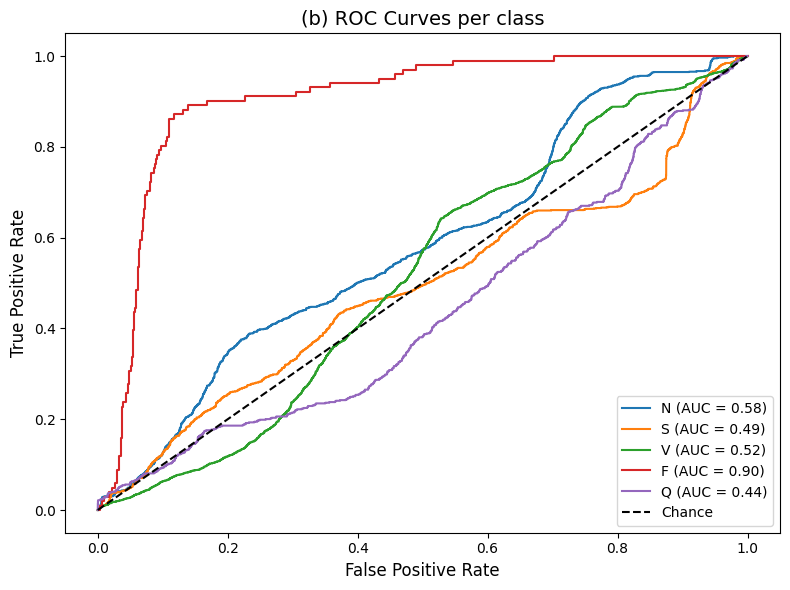

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --------------------
# Confusion Matrix
# --------------------
class_names = ['N', 'S', 'V', 'F', 'Q']

cm = confusion_matrix(all_true, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.title("(a) Confusion matrix of proposed model", fontsize=14)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# --------------------
# ROC Curves (one-vs-rest)
# --------------------
# Χρειάζεσαι τις πιθανότητες (softmax), όχι μόνο τις προβλέψεις
from sklearn.metrics import roc_auc_score

model.eval()
all_probs, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1)  # πιθανότητες
        all_probs.extend(probs.cpu().numpy())
        all_true.extend(yb.numpy())

all_probs = np.array(all_probs)        # shape (N, 5)
all_true = np.array(all_true)          # shape (N,)

# Binarize labels για one-vs-rest ROC
y_bin = label_binarize(all_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Diagonal baseline
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.title("(b) ROC Curves per class", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()
